# Full test ETNN configs determined by optuna

## Importing section

In [2]:
import os
import sys

from sklearn.metrics import r2_score
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm

from etnn.nn.baseline import create_baseline_model, calc_params
from etnn.tools.training import train_epoch, eval_epoch

sys.path.insert(0, os.path.pardir)

In [3]:
import pandas as pd
import torch

from etnn.routines.run_config import run_config, choice_optim, choice_loss, choice_trainloader, acquire_config_idx, \
    choice_dataset

import matplotlib.pyplot as plt

from etnn.tools.training_tools import ConfigStore, seeding_all, EpochControl, AccuracyManager

## Definitions section

In [4]:
def run_baseline_custom(
        model,
        config,
        device: str = "cuda" if torch.cuda.is_available() else 'cpu',
        dataset_path: str = "../../datasets"
):
    # definition of constants
    test_perc = 0.3

    # CHOICES FOR DATASET
    dataset, df_index = choice_dataset(config, dataset_path)

    # SPLITTING DATASET IN TRAIN AND VAL
    generator = torch.Generator().manual_seed(config.seed)
    train_ds, test_ds = random_split(
        dataset,
        [1 - test_perc, test_perc],
        generator=generator
    )

    # ESTABLISHMENT OF LOADERS
    train_loader = choice_trainloader(config, df_index, train_ds)

    test_loader = DataLoader(test_ds, batch_size=4 * config.batch_size, shuffle=False)

    # DEFINE LOSS AND OPTIMIZER
    criterion = choice_loss(config)

    # set seeds
    seeding_all(config.seed)

    # move model to device
    model = model.to(device)

    optimizer = choice_optim(config, model)

    # init storage containers
    train_loss = []
    test_loss = []
    train_r2 = []
    test_r2 = []

    # train for N epochs
    for _ in tqdm(range(config.num_max_epochs)):
        train_mean_loss, train_true_y, train_pred_y = train_epoch(
            model,
            train_loader,
            optimizer,
            device,
            criterion
        )

        test_mean_loss, test_true_y, test_pred_y = eval_epoch(
            model,
            test_loader,
            device,
            criterion
        )

        train_loss += [train_mean_loss.item()]
        test_loss += [test_mean_loss.item()]
        train_r2 += [r2_score(y_true=train_true_y, y_pred=train_pred_y)]
        test_r2 += [r2_score(y_true=test_true_y, y_pred=test_pred_y)]

    # fuze dataset and save
    df = pd.DataFrame({
        "epoch": list(range(1, config.num_max_epochs + 1)),
        "train_loss": train_loss,
        "test_loss": test_loss,
        "train_r2": train_r2,
        "test_r2": test_r2
    })

    return df

In [5]:
def create_plot(
        df,
        what: str = "r2"
) -> None:
    plt.figure()

    # plot train test and val
    for mode in ['train', 'test', 'val']:
        # plot training
        if f"{mode}_{what}" in df.columns:
            plt.plot(df.epoch, df[f"{mode}_{what}"], label=f"{mode}-{what}")

    plt.title(f"{what} plot")
    plt.xlabel("epoch")
    plt.ylabel("score")
    if what == "r2":
        plt.ylim(-1, +1)
    plt.legend()
    plt.show()

## Tree advanced label

Rank 1 parameter configuration: Unnamed: 0                                      19
number                                          19
value                                     0.964431
datetime_start          2023-12-08 20:22:37.897914
datetime_complete       2023-12-08 20:23:44.097088
duration                    0 days 00:01:06.199174
params_batcher                                True
params_learning_rate                      0.008466
params_n_dim_0                               353.0
params_n_dim_1                                 7.0
params_n_dim_2                               484.0
params_n_dim_3                                 NaN
params_n_layers                                  4
state                                     COMPLETE
Name: 19, dtype: object
model-parameters: 271938


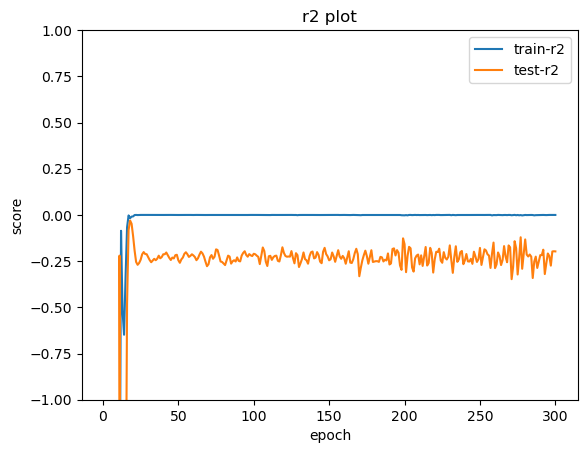

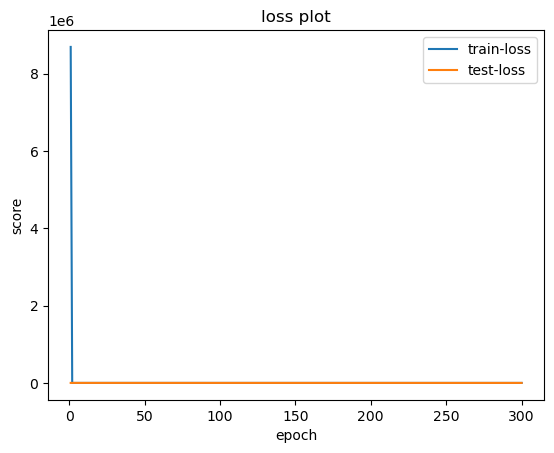

Rank 2 parameter configuration: Unnamed: 0                                      17
number                                          17
value                                      0.95799
datetime_start          2023-12-08 20:19:46.622146
datetime_complete       2023-12-08 20:21:13.501529
duration                    0 days 00:01:26.879383
params_batcher                                True
params_learning_rate                      0.009499
params_n_dim_0                               408.0
params_n_dim_1                                49.0
params_n_dim_2                                 NaN
params_n_dim_3                                 NaN
params_n_layers                                  3
state                                     COMPLETE
Name: 17, dtype: object
model-parameters: 326499


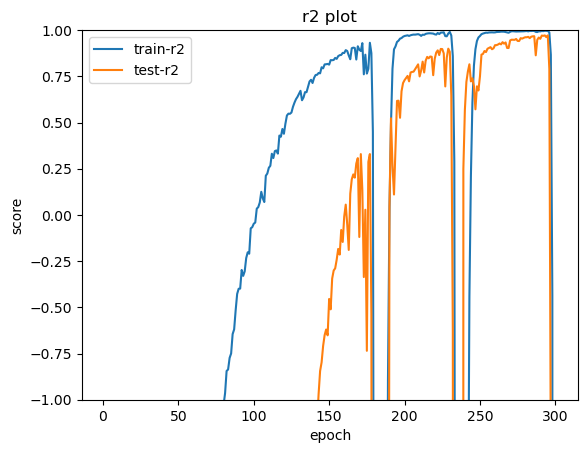

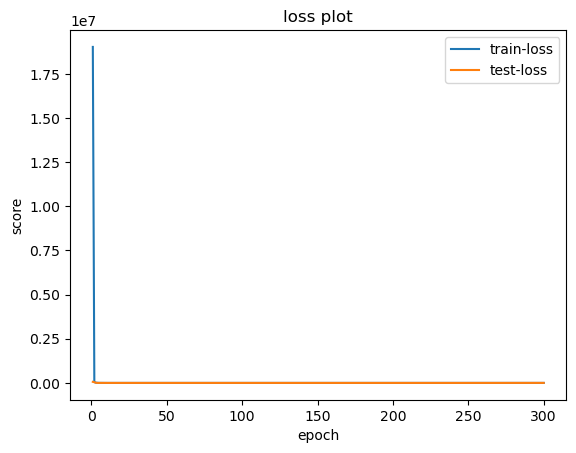

Rank 3 parameter configuration: Unnamed: 0                                      52
number                                          52
value                                     0.955541
datetime_start          2023-12-08 20:58:31.483234
datetime_complete       2023-12-08 20:59:36.995437
duration                    0 days 00:01:05.512203
params_batcher                                True
params_learning_rate                      0.008015
params_n_dim_0                               414.0
params_n_dim_1                                58.0
params_n_dim_2                                 NaN
params_n_dim_3                                 NaN
params_n_layers                                  3
state                                     COMPLETE
Name: 52, dtype: object
model-parameters: 335043


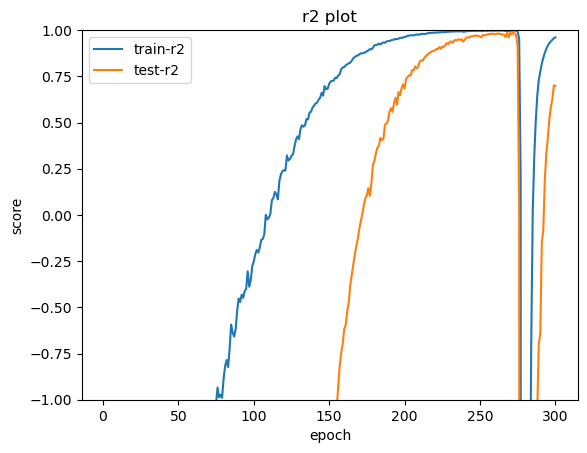

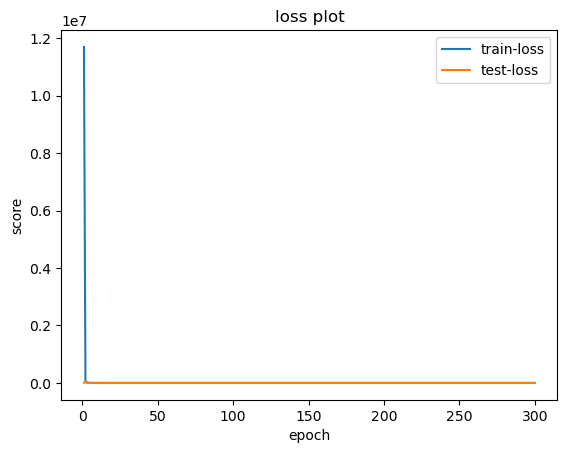

In [6]:
# define label to show
label = "tree_advanced"

# load config storage
config_table = pd.read_csv("study_label-tree-advanced_baseline_normalized.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}_normalized.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")

## Tree label

Rank 1 parameter configuration: Unnamed: 0                                      48
number                                          48
value                                     0.949696
datetime_start          2023-12-08 22:19:49.094493
datetime_complete       2023-12-08 22:21:17.553884
duration                    0 days 00:01:28.459391
params_batcher                               False
params_learning_rate                      0.007699
params_n_dim_0                               344.0
params_n_dim_1                                50.0
params_n_dim_2                               294.0
params_n_dim_3                                 NaN
params_n_layers                                  4
state                                     COMPLETE
Name: 48, dtype: object
model-parameters: 290883


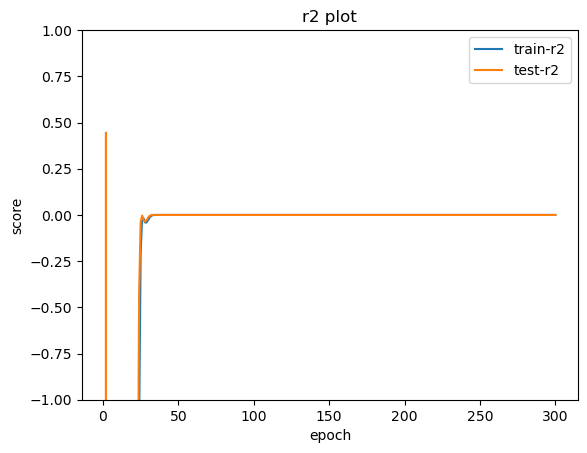

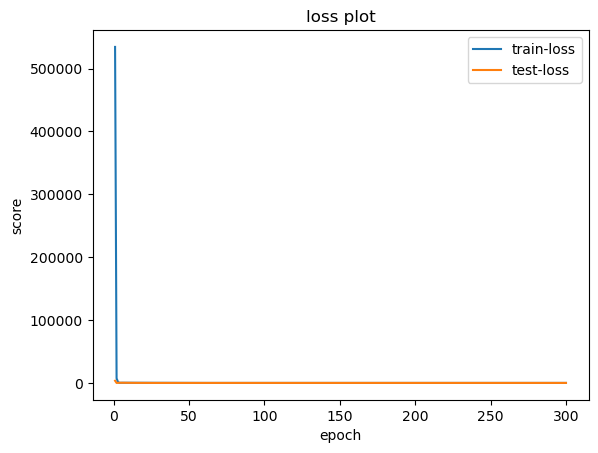

Rank 2 parameter configuration: Unnamed: 0                                      12
number                                          12
value                                     0.931667
datetime_start          2023-12-08 21:34:43.951475
datetime_complete       2023-12-08 21:35:55.972492
duration                    0 days 00:01:12.021017
params_batcher                                True
params_learning_rate                      0.009598
params_n_dim_0                               330.0
params_n_dim_1                               134.0
params_n_dim_2                                 NaN
params_n_dim_3                                 NaN
params_n_layers                                  3
state                                     COMPLETE
Name: 12, dtype: object
model-parameters: 292319


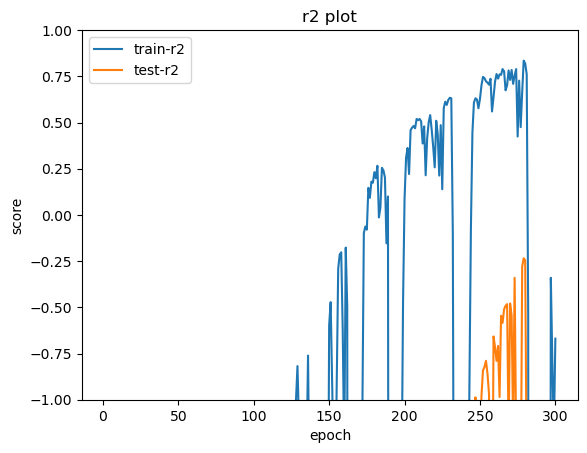

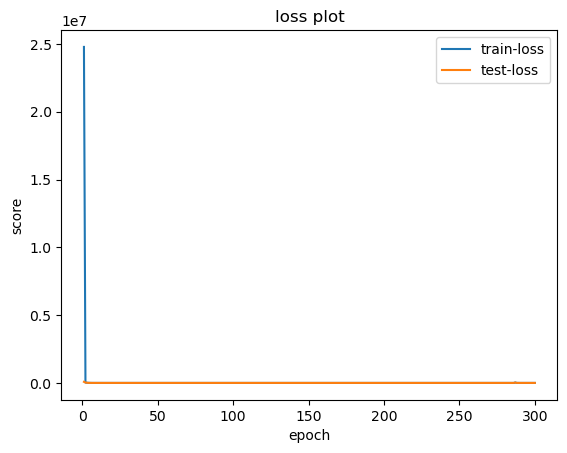

Rank 3 parameter configuration: Unnamed: 0                                      26
number                                          26
value                                     0.921453
datetime_start          2023-12-08 21:52:06.603549
datetime_complete       2023-12-08 21:53:21.133330
duration                    0 days 00:01:14.529781
params_batcher                                True
params_learning_rate                      0.005501
params_n_dim_0                               228.0
params_n_dim_1                               299.0
params_n_dim_2                                 NaN
params_n_dim_3                                 NaN
params_n_layers                                  3
state                                     COMPLETE
Name: 26, dtype: object
model-parameters: 239999


100%|██████████| 300/300 [21:24<00:00,  4.28s/it]


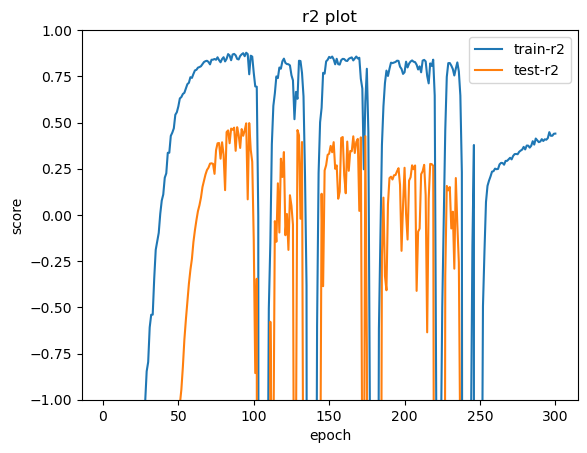

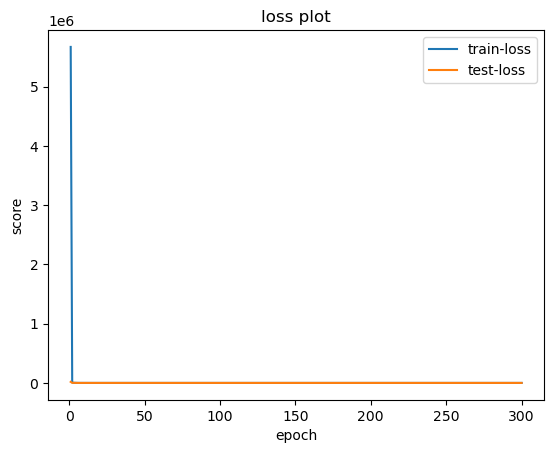

In [7]:
# define label to show
label = "tree"

# load config storage
config_table = pd.read_csv("study_label-tree_baseline_normalized.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}_normalized.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")

## Default label

Rank 1 parameter configuration: Unnamed: 0                                      12
number                                          12
value                                    -0.019113
datetime_start          2023-12-09 08:27:27.701608
datetime_complete       2023-12-09 08:28:48.599848
duration                    0 days 00:01:20.898240
params_batcher                               False
params_learning_rate                      0.008067
params_n_dim_0                               187.0
params_n_dim_1                               434.0
params_n_dim_2                                 1.0
params_n_dim_3                               511.0
params_n_layers                                  5
state                                     COMPLETE
Name: 12, dtype: object
model-parameters: 223998


100%|██████████| 300/300 [21:42<00:00,  4.34s/it]


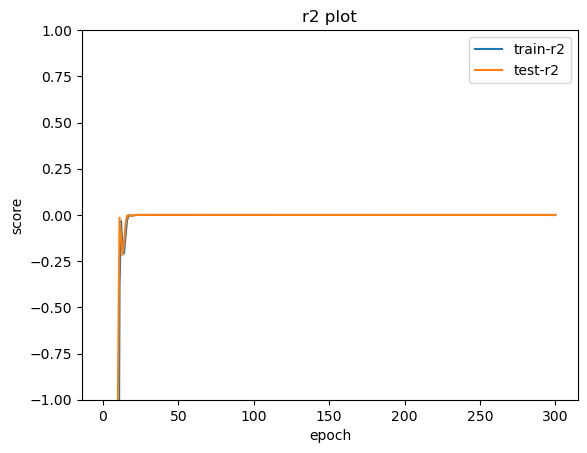

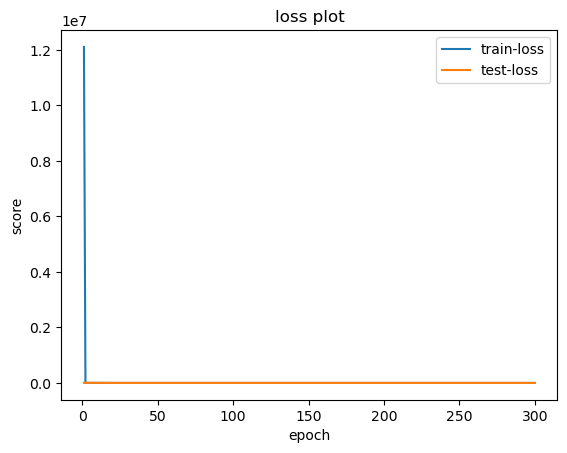

Rank 2 parameter configuration: Unnamed: 0                                      10
number                                          10
value                                    -0.021934
datetime_start          2023-12-09 08:24:29.572116
datetime_complete       2023-12-09 08:25:59.999904
duration                    0 days 00:01:30.427788
params_batcher                               False
params_learning_rate                      0.009049
params_n_dim_0                               207.0
params_n_dim_1                               411.0
params_n_dim_2                                12.0
params_n_dim_3                               505.0
params_n_layers                                  5
state                                     COMPLETE
Name: 10, dtype: object
model-parameters: 252960


100%|██████████| 300/300 [18:30<00:00,  3.70s/it]


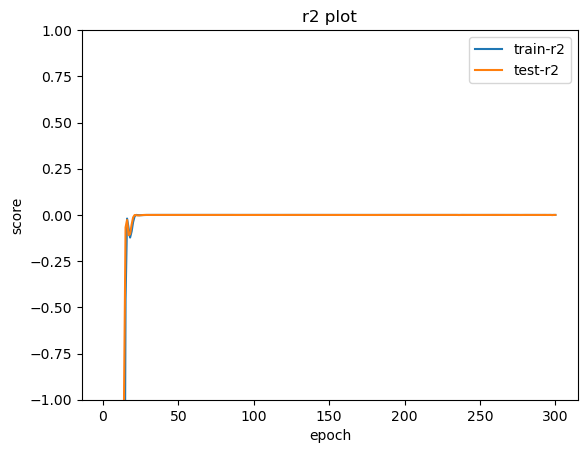

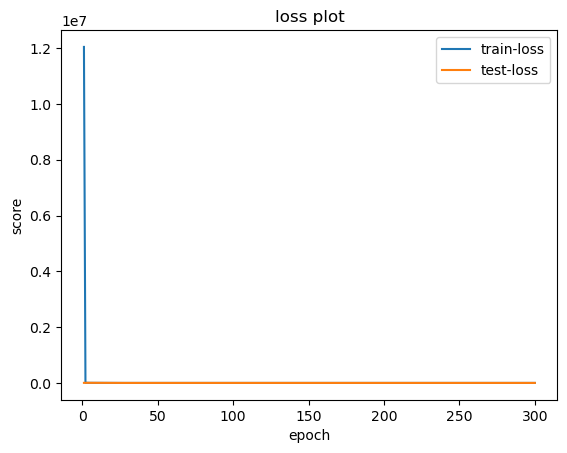

Rank 3 parameter configuration: Unnamed: 0                                      11
number                                          11
value                                    -0.052664
datetime_start          2023-12-09 08:26:00.001160
datetime_complete       2023-12-09 08:27:27.699607
duration                    0 days 00:01:27.698447
params_batcher                               False
params_learning_rate                      0.009829
params_n_dim_0                               203.0
params_n_dim_1                               402.0
params_n_dim_2                                11.0
params_n_dim_3                               496.0
params_n_layers                                  5
state                                     COMPLETE
Name: 11, dtype: object
model-parameters: 245343


100%|██████████| 300/300 [22:15<00:00,  4.45s/it]


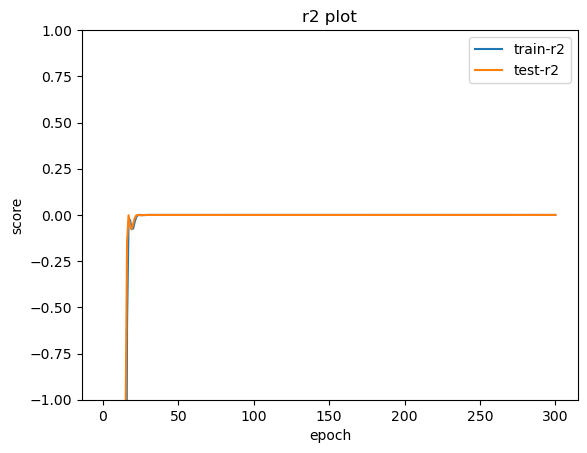

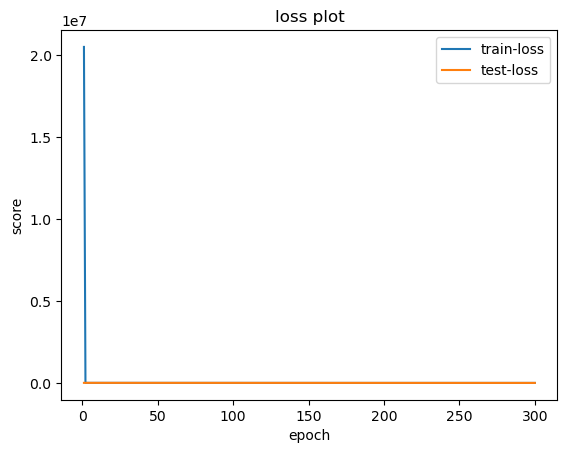

In [8]:
# define label to show
label = "default"

# load config storage
config_table = pd.read_csv("study_label-default_baseline_normalized.csv")

# sort config storage
config_table = config_table.sort_values(by=['value'], ascending=False)

# iterate over top 3 best configs
for i in range(3):
    # get entry from dataframe
    entry = config_table.iloc[i]

    # print information to console
    print(f"Rank {i+1} parameter configuration: {entry}")

    # setup config
    config = ConfigStore(
        in_dim=15,
        hidden_dim=0, # int(entry.params_hidden_dim),
        out_dim=1,
        k=0, # int(entry.params_k),
        dataset=0,
        ds_size=10_000,
        num_gondolas=10,
        num_part_pg=5,
        loss_name='mse',
        optimizer_name='adam',
        num_max_epochs=300,
        learning_rate=float(entry.params_learning_rate),
        batch_size=1024,
        early_stop_tol=5,
        use_equal_batcher=bool(entry.params_batcher),
        seed=420,
        label_type=label,
        final_label_factor=1/1000
    )

    # build model
    # define model
    layer_list = [torch.nn.Flatten()]
    features = config.in_dim * config.num_gondolas * config.num_part_pg

    # for each layer create a linear layer and relu (except last one)
    for layer in range(int(entry.params_n_layers)-1):
        # determine new feature dimension
        new_features = int(entry[f"params_n_dim_{layer}"])

        # add layer and relu to list
        layer_list += [torch.nn.Linear(features, new_features), torch.nn.ReLU()]

        # set the new feature to be the current feature
        features = new_features

    # set the last layer - this one must map to the out dimension
    layer_list += [torch.nn.Linear(features, config.out_dim)]
    model = torch.nn.Sequential(*layer_list)
    print(f"model-parameters: {calc_params(model)}")

    if os.path.isfile(f"baseline_label-{label}_rank-{i}_normalized.csv"):
        df = pd.read_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")
    else:
        # run config and retrieve measurements
        df = run_baseline_custom(
            model=model,
            config=config,
        )

        # save measurements
        df.to_csv(f"baseline_label-{label}_rank-{i}_normalized.csv")

    # plot results
    create_plot(df, what="r2")
    create_plot(df, what="loss")